In [ ]:
import pandas as pd
data = pd.read_csv("data.csv")
print(data.corr())
data = data.dropna(thresh = len(data)*9.5/10,axis=1)
data.fillna(data.mean(),inplace = True)
print(data.shape)

In [12]:
for i in data.columns:
    if len(set(data[i]))==1:
        data.drop(labels=[i], axis=1, inplace=True)

In [19]:
print(data.shape)


(105471, 158)


In [20]:
def remove_collinear_features(x, threshold):

    # Dont want to remove correlations between loss
    y = x['loss']
    x = x.drop(columns = ['loss'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)
    
    # Add the score back in to the data
    x['loss'] = y
               
    return x
data = remove_collinear_features(data, 0.6);


In [25]:
import numpy as np
y = data['loss'].values
data = data.drop(columns = 'loss')
fields = data.columns.values[:-1]
X = data[fields].values
for i in (range(len(y))):
    if(y[i]>0):
        y[i] = 1 

In [30]:
print(data.shape)
print(data.describe())
data['loan_status'] = y 
corr = data.corr()
cor_target = abs(corr['loan_status'])
print("Correlation with output",cor_target)


(105471, 157)
                  id             f1             f2             f3  \
count  105471.000000  105471.000000  105471.000000  105471.000000   
mean    52736.000000     134.603171       8.246883       0.499066   
std     30446.999458      14.725467       1.691535       0.288752   
min         1.000000     103.000000       1.000000       0.000006   
25%     26368.500000     124.000000       8.000000       0.248950   
50%     52736.000000     129.000000       9.000000       0.498267   
75%     79103.500000     148.000000       9.000000       0.749494   
max    105471.000000     176.000000      11.000000       0.999994   

                  f5             f6             f7             f8  \
count  105471.000000  105471.000000  105471.000000  105471.000000   
mean        7.354533   47993.704317    2974.336018    2436.363718   
std         5.151112   35677.136048    2544.352960    2261.866440   
min         1.000000       0.000000       1.000000       1.000000   
25%         4.00000

In [8]:
data_clean = data.drop(columns='loss')
data_clean['loan_status'] = y
data_clean.to_csv('loanCleaned.csv', index=False)

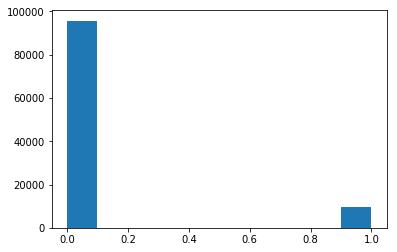

In [7]:
import matplotlib.pyplot as plt
data = pd.read_csv("loanCleaned.csv")
plt.hist(data['loan_status'])
plt.title("histogram of output")
plt.show()

In [19]:
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
from sklearn.preprocessing import StandardScaler
scl = StandardScaler()
data_clean = pd.DataFrame(scl.fit_transform(data[fields]), columns = fields)
data_clean['loan_status'] = y
data_clean.to_csv('loanCleaned.csv', index=False)


In [57]:
#ANN using PCA
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import KFold
from keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values


pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X = X_pca
ANN_pca_scores = []
fnr_val = []

kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    model = keras.Sequential([
        keras.layers.Dense(15, input_shape=(15,),activation='relu'),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(2,activation='softmax')
        ])
    model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    model.fit(X_train, y_train, epochs=30, batch_size=10000, verbose=0)
    y_pred = model.predict(X_test)
    score = accuracy_score(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1))*100
    tn, fp, fn, tp = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(y_pred,axis=1)).ravel()
    fnr_val.append(fn/len(y_test))
    ANN_pca_scores.append(score)
print("Accuracies from cross validation ",np.array(ANN_pca_scores))
print("False negative rates from cross validation ", np.array(fnr_val))
ANN_pca_acc = np.array(ANN_pca_scores).mean()
ANN_pca_fnr = np.array(fnr_val).mean()

Accuracies from cross validation  [91.08835798 91.10647578 90.86944155 91.58054423 90.65137006 90.03508107
 90.78410923 90.45226131 90.00663696 90.1488575 ]
False negative rates from cross validation  [0.08826318 0.08779748 0.09111596 0.08419456 0.0934863  0.09936475
 0.09083152 0.09320186 0.09936475 0.09851143]


In [58]:
#Linear svm with PCA
from sklearn.svm import LinearSVC
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
linear_svc_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X = X_pca
fnr_val = []

kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    svm = LinearSVC()
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    linear_svc_pca_scores.append(accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fnr_val.append(fn/len(y_test))
print("Accuracies obtained from cross validation", np.array(linear_svc_pca_scores))
print("False negative rates ", np.array(fnr_val))
linear_svc_pca_acc = np.array(linear_svc_pca_scores).mean()
linear_svc_pca_fnr = np.array(fnr_val).mean()

Accuracies obtained from cross validation [0.91173682 0.9092633  0.90888404 0.91580544 0.9065137  0.90044562
 0.90840997 0.90660851 0.90063525 0.90148857]
False negative rates  [0.08826318 0.08789229 0.09111596 0.08419456 0.0934863  0.09955438
 0.09159003 0.09339149 0.09936475 0.09851143]


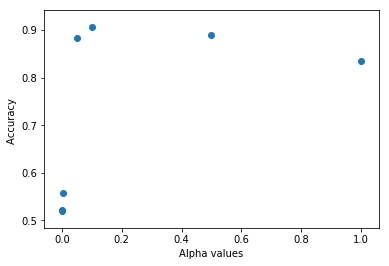

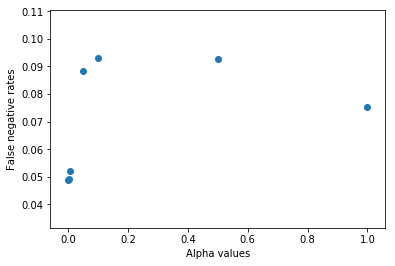

[91.16420174 63.22176922 84.44107329 91.58054423 90.56603774 90.04456243
 70.1336873  71.75500142 67.46942258 73.43320375]
[0.08826317785362153, 0.0491134919882431, 0.07879017730160236, 0.08419455769413103, 0.09348629942163648, 0.09955437565184412, 0.05290603963212288, 0.0559400777472267, 0.05176827533895895, 0.09301223096615151]


In [60]:
#Implementation of logistic regression with PCA
import math
import numpy as np
import pandas as pd
import keras
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from numpy import vstack
data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_m_pca_scores = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X = X_pca
def sigmoid(z):
    temp = 1 + (np.exp(-z))
    return 1/temp
def hypothesis(theta, x):
    
    if(sigmoid(np.dot(theta,x))<0.5):
        return 0
    else:
        return 1
def cost(theta, X, y):
    c = 0
    for i in range(len(X)):
        temp = hypothesis(theta, X[i])
        c = c + (-y[i]* np.log(temp) - (1-y[i])*np.log(1-temp)) 
    return c/len(X)
def gradient(x,theta,y):
    h = []
    for i in x:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    error = np.dot(x.T, (h-y))/y.shape[0]
    return np.array(error)
def gradient_descent(X,y,theta, alpha):
    num_iter = 350
    for i in range(num_iter):
        e = gradient(X,theta,y)
        theta = theta - alpha * e
    return theta, num_iter
def predict(theta, X):
    h = []
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    for i in X:
        h.append(hypothesis(theta,i))
    h = np.array(h)
    return h
def logistic_reg(X, y, X_test,alpha=0.1):
    temp = np.ones(len(X)).reshape(len(X),1)
    X = vstack((temp.T,X.T)).T
    theta = np.ones(X.shape[1])
    theta, num_iter = gradient_descent(X,y,theta,alpha)
    y_pred = predict(theta,X_test)
    return theta,y_pred
a_scores = []
a_fnr = []
alphas = [0.1,0.001, 0.0001, 0.5,0.05,0.005, 1]
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

for alpha in alphas:
    theta, y_pred = logistic_reg(X_train,y_train, X_test,alpha)
    a_scores.append(accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    a_fnr.append(fn/len(y_test))

plt.scatter(alphas, a_scores)
plt.xlabel("Alpha values")
plt.ylabel("Accuracy ")
plt.show()
plt.scatter(alphas, a_fnr)
plt.xlabel("Alpha values")
plt.ylabel("False negative rates")
plt.show()

fnr_scores = []
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    theta, y_pred = logistic_reg(X_train, y_train, X_test)
    lg_m_pca_scores.append(accuracy_score(y_test, y_pred))
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    fnr_scores.append(fn/len(y_test))
print(np.array(lg_m_pca_scores)*100)
print(fnr_scores)
LogReg_m_pca_acc = (np.array(lg_m_pca_scores)*100).mean()
LogReg_m_pca_fnr = np.array(fnr_scores).mean()


Accuracies from cross validation  [91.17368221 91.1918081  90.88840429 91.58054423 90.65137006 90.04456243
 90.84099744 90.66085143 90.06352517 90.1488575 ]
False negative rates from cross validation [0.08826318 0.08808192 0.09111596 0.08419456 0.0934863  0.09955438
 0.09159003 0.09339149 0.09936475 0.09851143]


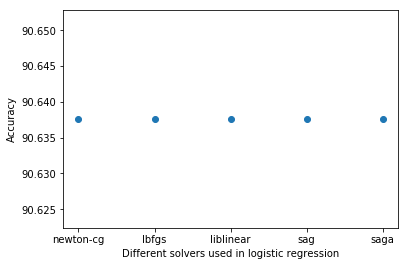

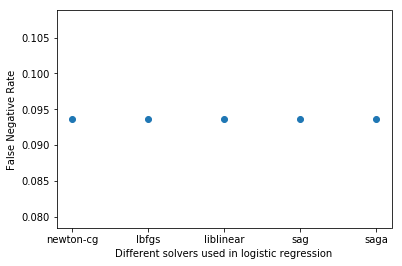

In [66]:
#Logistic regression using inbuilt class with PCA
import numpy as np
import pandas as pd
import keras
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
lg_wo_pca_scores = []
log_wo_pca_fnr = []
kf  = KFold(n_splits=10)
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X = X_pca
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    lg_wo_pca_scores.append(accuracy_score(y_test, y_pred)*100)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    log_wo_pca_fnr.append(fn/len(y_test))

LogReg_pca_acc = np.array(lg_wo_pca_scores).mean()
LogReg_pca_fnr = np.array(log_wo_pca_fnr).mean()
print("Accuracies from cross validation ",np.array(lg_wo_pca_scores))
print("False negative rates from cross validation", np.array(log_wo_pca_fnr))
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
scores_solvers = []
fnr_solvers = []
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

for s in solvers:
        model = LogisticRegression(solver=s).fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores_solvers.append(accuracy_score(y_test, y_pred)*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fnr_solvers.append(fn/len(y_test))
plt.scatter(solvers, scores_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('Accuracy')
plt.show()

plt.scatter(solvers, fnr_solvers)
plt.xlabel('Different solvers used in logistic regression')
plt.ylabel('False Negative Rate')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

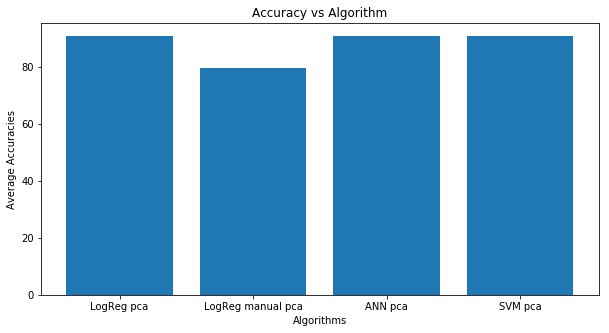

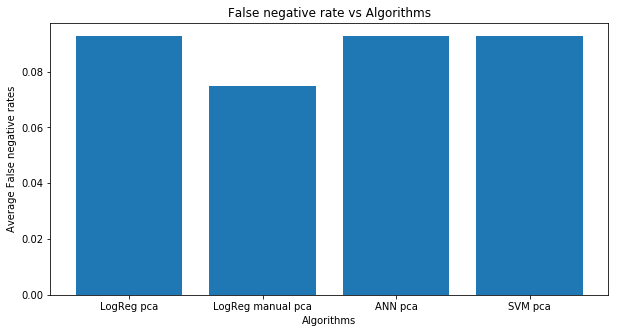

In [61]:
acc = [LogReg_pca_acc, LogReg_m_pca_acc, ANN_pca_acc, linear_svc_pca_acc*100]
fnr = [LogReg_pca_fnr, LogReg_m_pca_fnr, ANN_pca_fnr,linear_svc_pca_fnr]
algos = ["LogReg pca", "LogReg manual pca",  "ANN pca","SVM pca"]
plt.figure(figsize=(10,5))
plt.title("Accuracy vs Algorithm")
plt.bar(algos, acc)
plt.xlabel("Algorithms")
plt.ylabel("Average Accuracies")
plt.show()

plt.figure(figsize=(10,5))
plt.title("False negative rate vs Algorithms")
plt.bar(algos, fnr)
plt.xlabel("Algorithms")
plt.ylabel("Average False negative rates")
plt.show()

In [64]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.cluster import MiniBatchKMeans
def convert(y):
    a =[]
    for i in y:
        a.append(1-i)
    return np.array(a)    

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
mbkm_scores = []
mbkm_fnr = []
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y[train_index], y[test_index]
    s = X_pca[0]
    mbkm = MiniBatchKMeans(n_clusters=2).fit(X_train)
    pred = mbkm.predict(s.reshape(1,-1))
    y_pred = mbkm.predict(X_test)
    if(pred==0):
        score = accuracy_score(y_test, y_pred)
        mbkm_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mbkm_fnr.append(fn/len(y_test))
    else:
        temp = convert(y_test)
        score = accuracy_score(temp, y_pred)
        mbkm_scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        mbkm_fnr.append(fn/len(y_test))
print("Accuracies from cross validation",np.array(mbkm_scores))
print("False negative rates",np.array(mbkm_fnr))

mbkm_pca_acc = np.array(mbkm_scores).mean()
mbkm_pca_fnr = np.array(mbkm_fnr).mean()

Accuracies from cross validation [51.91505499 55.00142221 89.88337916 80.37356594 47.19825543 84.84877216
 90.81255333 80.69593249 57.71309377 45.14079833]
False negative rates [0.02246871 0.02256566 0.00199109 0.08068645 0.05394899 0.08884043
 0.09159003 0.07992794 0.0768939  0.06779179]


In [69]:

#Kmeans manual with pca
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import euclidean_distances as ed
from sklearn.decomposition import PCA
def convert(y):
    a =[]
    for i in y:
        a.append(1-i)
    return np.array(a)    

data = pd.read_csv('loanCleaned.csv')
fields = data.columns.values[:-1]
X = data[fields].values
data['loan_status'] = data['loan_status'].apply(lambda x:int(x))
y = data['loan_status'].values
pca = PCA(n_components = 15)
X_pca = pca.fit_transform(X)
X = X_pca
def kmeansc(X, y):
    c1 = np.random.rand(1,X.shape[1])
    c2 = np.random.rand(1,X.shape[1])
    oldc1 = np.zeros(X.shape[1])
    oldc2 = np.zeros(X.shape[1])
    
    while (np.all(oldc1 != c1) and np.all(oldc2!=c2)):
        distance1 = ed(X, c1.reshape(1,-1))
        distance2 = ed(X, c2.reshape(1, -1))
        count1 = 0
        count2 = 0
        sum1 = [0] * X.shape[1]
        sum2 = [0] * X.shape[1]
        sum1 = np.array(sum1)
        sum2 = np.array(sum2)
        for i in range(len(distance1)):
            if(distance1[i,0] < distance2[i,0]):
                sum1 = sum1 + X[i,:]
                count1 = count1 + 1
            else:
                sum2 = sum2 + X[i,:]
                count2 = count2 + 1
        oldc1 = c1
        oldc2 = c2
        c1 = sum1/count1
        c2 = sum2/count2
    return c1, c2


def predict(X, c1, c2):
    distance1 = ed(X, c1.reshape(1, -1))
    distance2 = ed(X, c2.reshape(1, -1))
    label = []
    for i in range(len(distance1)):
            if(distance1[i, 0] < distance2[i, 0]):
                label.append(0)
            else:
                label.append(1)
    return np.array(label)
scores = []
fnr_val = []
kf  = KFold(n_splits=10)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    s = X[0]
    c1, c2 = kmeansc(X_train, y_train)
    
    pred = predict(s.reshape(1,-1),c1,c2)
    y_pred = predict(X_test,c1,c2)
    if(pred==0):
        score = accuracy_score(y_test, y_pred)
        scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fnr_val.append(fn/len(y_test))
    else:
        temp = convert(y_test)
        score = accuracy_score(temp, y_pred)
        scores.append(score*100)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        fnr_val.append(fn/len(y_test))
print("Accuracies from cross validation",np.array(scores))
print("False negative rates",np.array(fnr_val))

kmeans_m_pca_acc = np.array(scores).mean()
kmeans_m_pca_fnr = np.array(fnr_val).mean()

Accuracies from cross validation [41.97952218 43.95562719 46.42078316 42.67564236 39.89760121 40.78884991
 43.25400588 43.7091116  46.07945387 47.40684555]
False negative rates [0.03365567 0.03147815 0.06011188 0.02872855 0.05812079 0.03375367
 0.05641415 0.05840523 0.06674884 0.02872855]


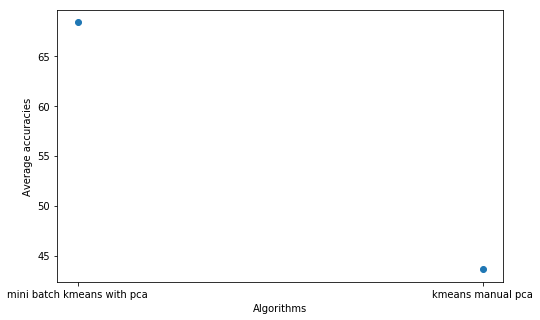

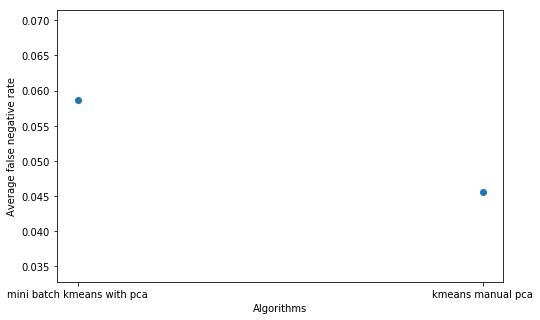

In [71]:
from matplotlib import pyplot as plt
algos = ["mini batch kmeans with pca", "kmeans manual pca"]
acc = [mbkm_pca_acc, kmeans_m_pca_acc]
fnr = [mbkm_pca_fnr, kmeans_m_pca_fnr]

plt.figure(figsize=(8,5))
plt.scatter(algos, acc)
plt.xlabel("Algorithms")
plt.ylabel("Average accuracies")
plt.show()

plt.figure(figsize=(8,5))
plt.scatter(algos, fnr)
plt.xlabel("Algorithms")
plt.ylabel("Average false negative rate")
plt.show()